#### Вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Нужно написать функцию для его подсчета, используя Python.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных необходимо определить, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import bootstrap
from scipy.stats import norm
import requests 
from urllib.parse import urlencode 

# Задание 1
Retention – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [2]:
# читаем файлы
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';') # данные о времени регистрации
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';') # данные о времени захода пользователей в игру

In [3]:
# для начала работаем с данными о времени регистрации пользователей
# смотрим, как выглядит датасет
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
# смотрим размер датасета
reg_data.shape

(1000000, 2)

In [5]:
# смотрим типы данных
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [6]:
# приводим колонку 'reg_ts' к нужному типу данных
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')

In [7]:
# проверяем на количество пропусков
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [8]:
# пропусков нет, переходим к данным о времени захода пользователей в игру. Делаем то же самое, что и с предыдущим датасетом
# смотрим, как выглядит датасет
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
# смотрим размер датасета
auth_data.shape

(9601013, 2)

In [10]:
# смотрим типы данных
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [11]:
# приводим колонку 'auth_ts' к нужному типу данных
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')

In [12]:
# проверяем на количество пропусков
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [13]:
# смотрим итог
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [14]:
auth_data.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [15]:
def calculate_retention(reg_data, auth_data, date_start, date_end):
    # объединим таблицы по уникальному id
    merged_df = pd.merge(reg_data, auth_data, on='uid')
    
    # приведем колонки времени регистрации и автторизации к формату даты
    merged_df['reg_ts'] = pd.to_datetime(merged_df['reg_ts'], unit='s').dt.floor('d')
    merged_df['auth_ts'] = pd.to_datetime(merged_df['auth_ts'], unit='s').dt.floor('d')
    
    # рассчитаем разницу между датой регистрации и датой авторизации (целевого действия)
    merged_df['days_since_registration'] = (merged_df['auth_ts'] - merged_df['reg_ts'])
    
    # оставим только интересующий период
    merged_df = merged_df.query('@date_start <= reg_ts <= @date_end')
    
    # создадим когорты по дате регистрации
    cohorts = merged_df.groupby(['reg_ts', 'days_since_registration'], as_index=False).agg({'uid': 'nunique'})
    
    # переименуем колонку
    cohorts = cohorts.rename(columns={'reg_ts': 'cohort'})
    
    # изменим таблицу для визуализации
    retention_rates = cohorts.pivot(index='cohort', columns='days_since_registration', values='uid')
    retention_rates = retention_rates.div(retention_rates.iloc[:,0], axis = 0)
    retention_rates = retention_rates.style.format("{:.2%}", na_rep='')
    
    return retention_rates

In [16]:
calculate_retention(reg_data, auth_data, date_start = '2020-09-09', date_end = '2020-09-23')

days_since_registration,0 days 00:00:00,1 days 00:00:00,2 days 00:00:00,3 days 00:00:00,4 days 00:00:00,5 days 00:00:00,6 days 00:00:00,7 days 00:00:00,8 days 00:00:00,9 days 00:00:00,10 days 00:00:00,11 days 00:00:00,12 days 00:00:00,13 days 00:00:00,14 days 00:00:00
cohort,,,,,,,,,,,,,,,
2020-09-09 00:00:00,100.00%,1.74%,3.24%,4.67%,5.72%,6.66%,5.72%,5.91%,4.36%,5.04%,3.73%,5.04%,4.79%,4.85%,2.43%
2020-09-10 00:00:00,100.00%,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%,
2020-09-11 00:00:00,100.00%,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,,
2020-09-12 00:00:00,100.00%,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,,
2020-09-13 00:00:00,100.00%,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,,
2020-09-14 00:00:00,100.00%,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,,
2020-09-15 00:00:00,100.00%,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,,
2020-09-16 00:00:00,100.00%,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,,
2020-09-17 00:00:00,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,,


# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [17]:
# читаем файл
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url, sep=';') 

In [18]:
# смотрим, как выглядит датасет
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [19]:
# смотрим размер датасета
df.shape

(404770, 3)

In [20]:
# смотрим количество пустых значений
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

В датасете есть исходная колонка с показателем выручки 'revenue', посмотрим на распределение этих данных с помощью графиков

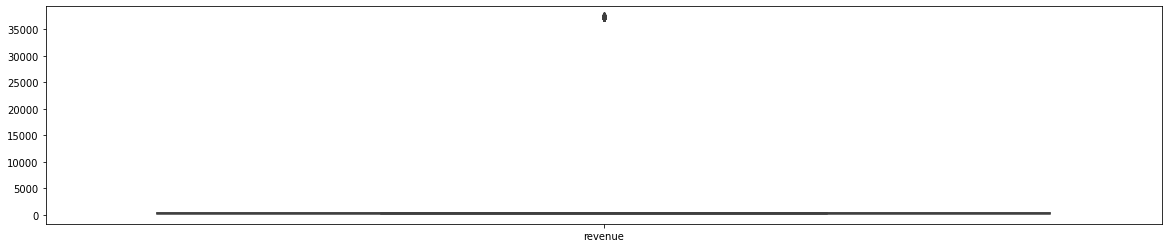

In [21]:
plt.figure(figsize=(20, 4))
sns.boxplot(data=df.query("testgroup == 'a' & revenue>0")[['revenue']])

In [22]:
# видим, что в контрольной группе a имеется выброс, а значит, данные распределены неравномерно.
# найдем максимальное, медианное и минимальное значение выручки в группе а.
print(
'Максимальная выручка в группе a:', df.query('testgroup == "a" & revenue > 0')['revenue'].max(),   
'\nМедианная выручка в группе a:', df.query('testgroup == "a" & revenue > 0')['revenue'].median(),   
'\nМинимальная выручка в группе a:', df.query('testgroup == "a" & revenue > 0')['revenue'].min(),
)

Максимальная выручка в группе a: 37433 
Медианная выручка в группе a: 311.0 
Минимальная выручка в группе a: 200


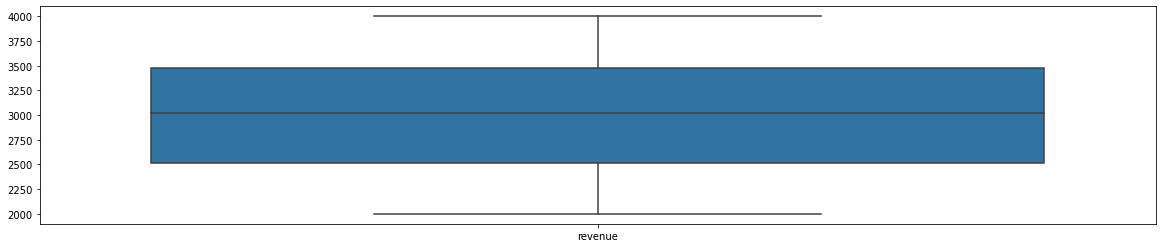

In [23]:
# теперь сделаем то же самое с группой b
# строим график
plt.figure(figsize=(20, 4))
sns.boxplot(data=df.query("testgroup == 'b' & revenue>0")[['revenue']])

In [24]:
# смотрим максимальное, медианное и минимальное значение выручки в группе b
print(
'Максимальная выручка в группе a:', df.query('testgroup == "b" & revenue > 0')['revenue'].max(),   
'\nМедианная выручка в группе a:', df.query('testgroup == "b" & revenue > 0')['revenue'].median(),   
'\nМинимальная выручка в группе a:', df.query('testgroup == "b" & revenue > 0')['revenue'].min(),
)

Максимальная выручка в группе a: 4000 
Медианная выручка в группе a: 3022.0 
Минимальная выручка в группе a: 2000


Можем заметить, что медианное значение выручки в группе b почти в 10 раз выше, чем медианное значение выручки в группе a.

Кроме того, в группе a распределение значений сильно неравномерное: покупки в этой группе либо слишком дорогие, либо слишком недорогие.

В то время как в группе b значения распределены равномерно, размах графика небольшой.

In [25]:
# считаем общее количество пользователей в каждой группе
users_count_df = df.groupby('testgroup',as_index=False)\
                   .agg({'user_id':'nunique'})\
                   .rename(columns={'user_id':'all_users'})
users_count_df

,testgroup,all_users
0,a,202103
1,b,202667


In [26]:
# группируем исходный датасет и уберем тех пользователей, у которых выручка равнялась нулю
paying_users_df = df.query('revenue > 0') \
               .groupby('testgroup',as_index=False) \
               .agg({'user_id':'nunique', 'revenue': 'sum'}) \
               .rename(columns={'user_id':'paying_users'})
paying_users_df

,testgroup,paying_users,revenue
0,a,1928,5136189
1,b,1805,5421603


In [27]:
# соединяем два датафрейма
test_groups = users_count_df.merge(paying_users_df, how = 'left', on = 'testgroup')
test_groups

,testgroup,all_users,paying_users,revenue
0,a,202103,1928,5136189
1,b,202667,1805,5421603


In [28]:
# добавим колонку со значением конверсии в покупку
test_groups['CR'] = (test_groups['paying_users'] / test_groups['all_users'] * 100).round(2)

In [29]:
# добавим колонку со средним значением выручки на пользователя
test_groups['ARPU'] = (df.groupby('testgroup',as_index=False)\
                    .agg({'revenue':'mean'})).round(2).revenue

In [30]:
# добавим колонку со средним значением выручки на платящего пользователя
test_groups['ARPPU'] = (df.query('revenue > 0')\
                    .groupby('testgroup',as_index=False)\
                    .agg({'revenue':'mean'})).round(2).revenue

In [31]:
# смотрим итог
test_groups

,testgroup,all_users,paying_users,revenue,CR,ARPU,ARPPU
0,a,202103,1928,5136189,0.95,25.41,2664.00
1,b,202667,1805,5421603,0.89,26.75,3003.66


Согласно исходным данным, в контрольной группе 1928 платящих пользователей, а в тестовой – 1805. Поэтому делаем заключение, что группа А - это контрольная группа, а группа B - тестовая.

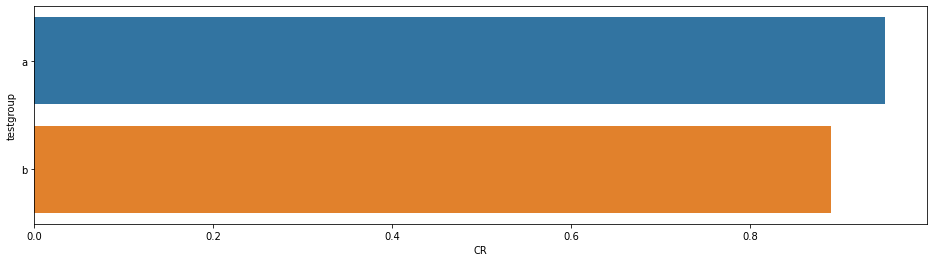

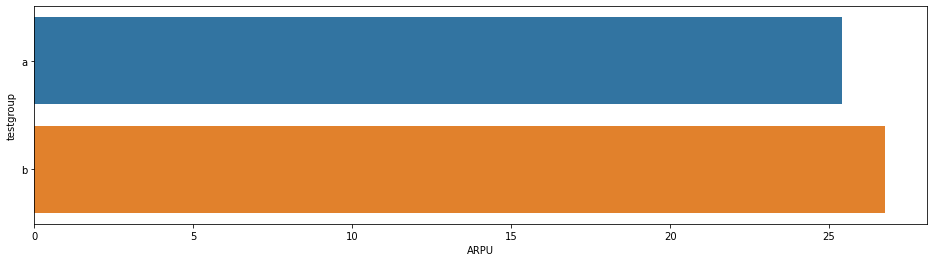

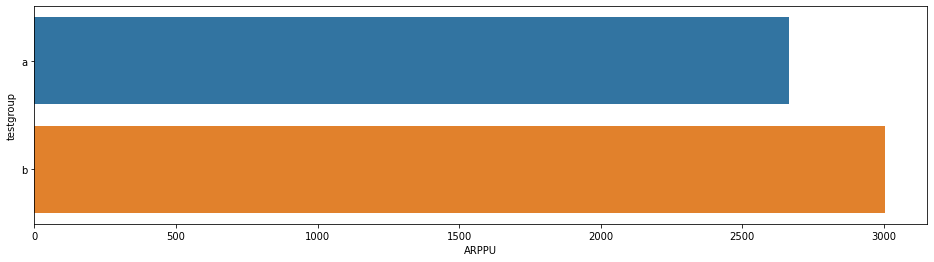

In [32]:
# сделаем графики для визуализации показателей CR, ARPU, ARPPU
plt.figure(figsize=(16, 4))
sns.barplot(x='CR', y='testgroup', data=test_groups)

plt.figure(figsize=(16, 4))
sns.barplot(x='ARPU', y='testgroup', data=test_groups)

plt.figure(figsize=(16, 4))
sns.barplot(x='ARPPU', y='testgroup', data=test_groups)

Видим, что количество покупок в группе a выше, чем в группе b, но выручка в разрезе на пользователя и платящего пользователя выше в группе b.

Необходимо проверить, являются ли эти различия в ARPU и ARPPU статистически значимыми. Для проверки гипотез будем использовать t-test.

Сначала будем работать с ARPU.

### Нулевая гипотеза: ARPU в контрольной(a) и ARPU в тестовой(b) группах не различаются.

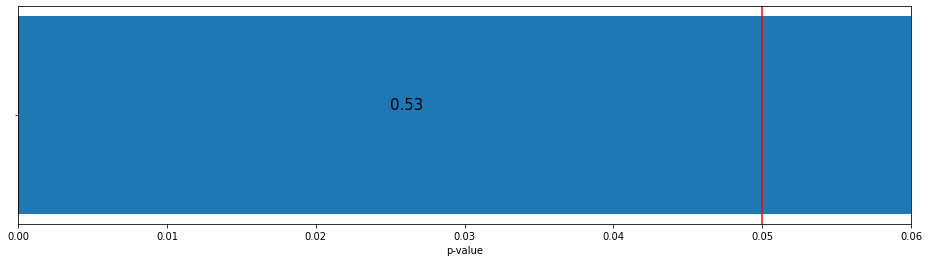

Нулевая гипотеза не отклоняется, нет статистически значимой разницы


In [33]:
# используем библиотеку scipy и модуль stats
a = 0.05
p = (stats.ttest_ind(df.query('testgroup == "a"')['revenue'],\
                     df.query('testgroup == "b"')['revenue'])[1]).round(2)

fig, ax = plt.subplots(figsize=(16, 4))
ax.barh([''],[p])

ax.axvline(0.05, color='r')

ax.set(xlim=[0, 0.06], xlabel='p-value')
ax.text(0.025, 0.025, p, color='black', fontsize=15)

plt.show()

if p < a:
    print('Нулевая гипотеза отклоняется, есть статистически значимая разница')
else:
    print('Нулевая гипотеза не отклоняется, нет статистически значимой разницы')
    

#### t-test не выявил статистически значимых различий между ARPU в контрольной(a) и ARPU в тестовой(b) группах.

Теперь проверим, являются ли различия в ARPPU между группами статистически значимыми. 

### Нулевая гипотеза: ARPPU в контрольной(a) и ARPPU в тестовой(b) группах не различаются.

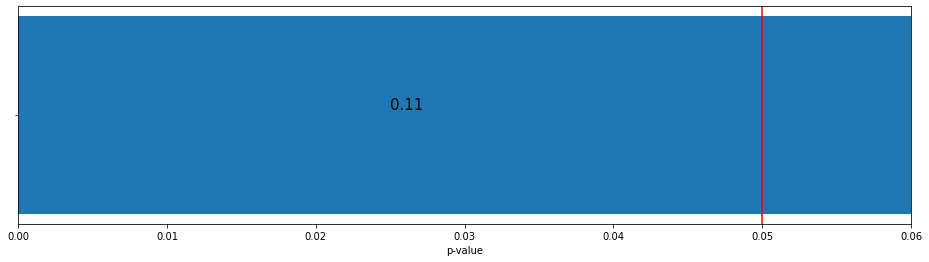

Нулевая гипотеза не отклоняется, нет статистически значимой разницы


In [34]:
a = 0.05
p = (stats.ttest_ind(df.query('testgroup == "a" & revenue>0')['revenue'],\
                     df.query('testgroup == "b" & revenue>0')['revenue'])[1]).round(2)

fig, ax = plt.subplots(figsize=(16, 4))
ax.barh([''],[p])

ax.axvline(0.05, color='r')

ax.set(xlim=[0, 0.06], xlabel='p-value')
ax.text(0.025, 0.025, p, color='black', fontsize=15)

plt.show()

if p < a:
    print('Нулевая гипотеза отклоняется, есть статистически значимая разница')
else:
    print('Нулевая гипотеза не отклоняется, нет статистически значимой разницы')

#### t-test также не выявил статистически значимых различий между ARPPU в контрольной(a) и ARPPU в тестовой(b) группах.

T-test не выявил статистически значимых различий ARPPU и ARPU в разрезе групп a и b.

### Таким образом, на основании проведенного теста можно предположить, что набор акционных предложений никак не повлиял на метрики ARPPU и ARPU.

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### В первую очередь необходимо отслеживать следующие метрики:

1. Количество сессий всего и количество сессий на пользователя
2. Средняя длительность сессии каждого пользователя
3. Конверсия в покупку уникальных предметов, монет и бонусов (CR)
4. Средняя выручка на пользователя (ARPU) и выручка на платящего пользователя (ARPPU), общая выручка
5. Коэффициент удержания (Retention)
6. Количество активных пользователей в день/неделю/месяц (DAU, WAU, MAU)

Перечисленные метрики целесообразно отслеживать не только в период тематического события, но и в его отсутствие, чтобы была возможность сравнения показателей в разные периоды.

В случае, если при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад, к указанным метрикам может добавиться количество игроков, которые "откатились", а также более подробное рассмотрение перечисленных метрик, относящихся к таким игрокам. 

В зависимости от получившихся результатов нужно будет рассмотреть возможность внедрения принципа "отката" на последующие тематические события либо отказ от такого принципа.
